In [1]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.trend_filter as tfilter
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/Lorenz63_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)


# 2) LOAD OBSERVATION SAMPLES
Y_samples = []
noise_lvl = '0.001'

for state in range(n_states):
    
    filepath = 'data_files/Lorenz63_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
    y = np.genfromtxt(filepath, delimiter=',')
        
    Y_samples.append(y)
    
n_samples = Y_samples[0].shape[0]

lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 times...
lambda_min too small. Increasing it 10 t

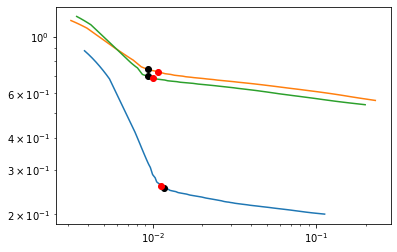

In [3]:
################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
Y_tf = np.zeros((t_samples, n_states))
DY_tf = np.zeros((t_samples, n_states))
error_X = np.zeros((n_samples,n_states))
error_dX = np.zeros((n_samples,n_states))
trim = int(np.floor(5 / 100 * t_samples))


for sample in range(1):
    #CVX code
    for state in range(n_states):
        
        y = Y_samples[state][sample,:]
        
        tf_flc = tfilter.full_lcurve(y, order = 3, lambda_min = 1e-16, lambda_max = 1)
        tf_path = tf_flc[0]
        res, reg = tf_flc[1]
        error_path = np.zeros(tf_path.shape[1])
        for i in range(tf_path.shape[1]):
            error_path[i] = norm(tf_path[:,i] - X[state,:]) / norm(X[state,:])
        
        min_indx = np.argmin(error_path)
        #Find corner point
        tf_lc = tfilter.lcurve_corner(y, order = 3, lambda_min = 1e-16, lambda_max = 1)
        y_tf = tf_lc[0]
        resc, regc = tf_lc[3]
        plt.loglog(res, reg)
        plt.loglog(res[min_indx], reg[min_indx],'ko')
        plt.loglog(resc[-1], regc[-1], 'ro')
        
        y_tf_ss = interpolate.splrep(t, y_tf, k=3, s=0)
        dy_tf = interpolate.splev(t, y_tf_ss, der=1)
        
        #Remove ends
        Yhat_tf = y_tf[trim:-trim]
        DYhat_tf = dy_tf[trim:-trim]
        #Compute errors
        error_X[sample,state] = norm(Yhat_tf - X[state,trim:-trim]) / norm(X[state,trim:-trim])
        error_dX[sample,state] = norm(DYhat_tf - DX[state,trim:-trim]) / norm(DX[state,trim:-trim])

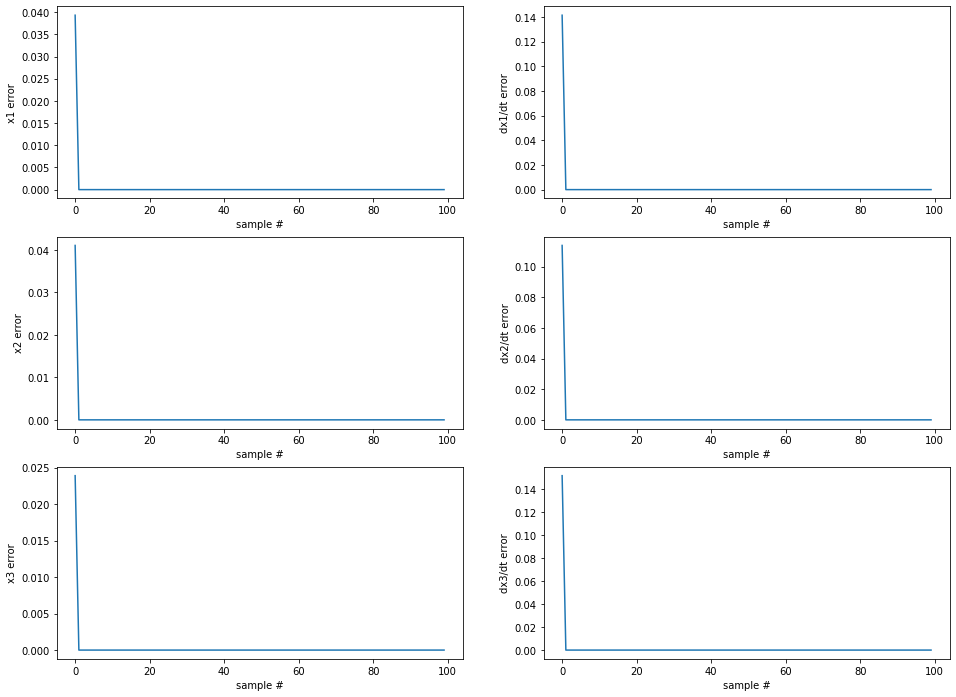

In [24]:
fig, ax = plt.subplots(n_states,2, figsize = (16,12))

for state in range(n_states):
    ax[state][0].plot(error_X[:,state])
    ax[state][0].set_ylabel(f'x{state+1} error')
    ax[state][0].set_xlabel('sample #')
    ax[state][1].plot(error_dX[:,state])
    ax[state][1].set_ylabel(f'dx{state+1}/dt error')
    ax[state][1].set_xlabel('sample #')

In [25]:
mean_X_error = np.zeros(n_states)
mean_dX_error = np.zeros(n_states)

var_X_error = np.zeros(n_states)
var_dX_error = np.zeros(n_states)

ind_names = []
col_names = ['mean error x', 'var. error x', 'mean error dx', 'var. error dx']

for state in range(n_states):
    mean_X_error[state] = error_X[:,state].mean()
    mean_dX_error[state] = error_dX[:,state].mean()
    var_X_error[state] = error_X[:,state].var()
    var_dX_error[state] = error_dX[:,state].var()
    ind_names.extend(['state x' + str(state+1)])
    

In [26]:
errors = pd.DataFrame(np.array([mean_X_error, var_X_error, mean_dX_error, var_dX_error]).T, index = ind_names, columns=col_names)
errors

,mean error x,var. error x,mean error dx,var. error dx
state x1,0.000393,0.000015,0.001414,0.000198
state x2,0.000410,0.000017,0.001139,0.000128
state x3,0.000239,0.000006,0.001520,0.000229
